In [ ]:
import pandas as pd #for dealing with csv files   [2]
import matplotlib.pyplot as plt #for plotting purposes
import seaborn as sns #for plotting purposes
from sklearn.svm import SVC #to work on SVM model
from sklearn.model_selection import train_test_split, GridSearchCV  #to split data into training and val; to obtain best parameters for any model
from sklearn.metrics import accuracy_score #to get the accuracy score for model evaluation
from sklearn import inspection  #to obtain the feature importances
from sklearn.ensemble import RandomForestClassifier  #to work on RF model
from sklearn.neural_network import MLPClassifier  #to work on neural network model
from sklearn.feature_selection import RFECV  #for feature elimination in RF model
from sklearn.preprocessing import MinMaxScaler  #to scale features

### step 1

In [ ]:
#1

df=pd.read_csv(r"\bank.csv") #read the bank.csv file
print(df.dtypes) #check for data type inconsistency

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
deposit      object
dtype: object


In [ ]:
#check number of unique values in each columns
for i in (df.columns): #iterate over all columns
    print()
    print(df[i].value_counts())  #print each unique column entry with their count  #[1]


age
31    496
32    477
34    466
33    464
35    461
     ... 
92      2
88      2
93      2
95      1
89      1
Name: count, Length: 76, dtype: int64

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

marital
married     6351
single      3518
divorced    1293
Name: count, dtype: int64

education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64

default
no     10994
yes      168
Name: count, dtype: int64

balance
 0       774
 1        39
 3        35
 2        34
 4        29
        ... 
 8585      1
-159       1
-132       1
 4576      1
 6691      1
Name: count, Length: 3805, dtype: int64

housing
no     5881
yes    5281
Name: count, dtype: int64

loan
no     9702
yes    1460
Name: count, dt

#step1
#### observations:
- Poutcome is not usable since it has way too many unknowns, and is severely unbalanced
- deposit (target variable) is well balanced and we use both classes (yes and no)
- we can't use "duration" as a predicting feature since we get the duration of the call only after the call is made.
- Using "days" columns is pointless however "month" may be useful

In [ ]:
#1

# now we try to find the correlation between each columns
# for this we encode all string-valued columns

for i in df.columns: #iterate all features
    if df[i].dtype=='object':   #check for string datatype in columns
        df[i],unique_vals = pd.factorize(df[i])  #encode string-values to integers  #[3]
        print(unique_vals)    #to get the order in which the unique values are encoded


Index(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid', 'unknown',
       'self-employed', 'student'],
      dtype='object')
Index(['married', 'single', 'divorced'], dtype='object')
Index(['secondary', 'tertiary', 'primary', 'unknown'], dtype='object')
Index(['no', 'yes'], dtype='object')
Index(['yes', 'no'], dtype='object')
Index(['no', 'yes'], dtype='object')
Index(['unknown', 'cellular', 'telephone'], dtype='object')
Index(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb', 'mar',
       'apr', 'sep'],
      dtype='object')
Index(['unknown', 'other', 'failure', 'success'], dtype='object')
Index(['yes', 'no'], dtype='object')


                age       job   marital  education   default   balance  \
age        1.000000 -0.011582 -0.141610   0.184834 -0.011425  0.112300   
job       -0.011582  1.000000 -0.015023   0.226336  0.019306  0.017919   
marital   -0.141610 -0.015023  1.000000  -0.038460  0.013950 -0.026316   
education  0.184834  0.226336 -0.038460   1.000000  0.008501  0.048036   
default   -0.011425  0.019306  0.013950   0.008501  1.000000 -0.060954   
balance    0.112300  0.017919 -0.026316   0.048036 -0.060954  1.000000   
housing    0.168700  0.101952  0.022530   0.088135 -0.011076  0.077092   
loan      -0.031418 -0.053190 -0.019343  -0.068010  0.076434 -0.084589   
contact    0.135411  0.021981 -0.016336   0.039878 -0.045252  0.067053   
day       -0.000762 -0.009758 -0.001393   0.009543  0.017342  0.010467   
month      0.073777  0.022391  0.000692   0.014184 -0.038603  0.068049   
duration   0.000189  0.015517  0.035748  -0.004549 -0.009760  0.022436   
campaign  -0.005278 -0.010002 -0.03728

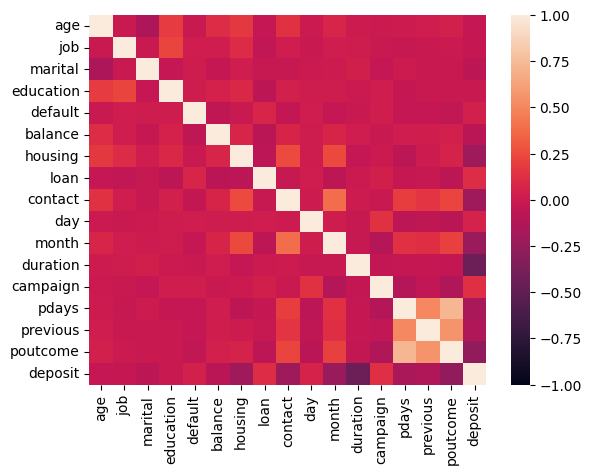

In [ ]:
corr_matrix=df.corr()  #obtain correlation between all columns  #[2]
print(corr_matrix) #print correlations
sns.heatmap(corr_matrix,vmin=-1, vmax=1, annot=False)  #display corresponding heatmap
plt.show() #show plot

### Observation:
- we can see that only **age, housing, balance, loan, month, campaign, previous, pdays** have significant correlations with __deposit__
- everything else is almost close to zero, thus I chose to ignore those features initially and then further perform feature elimination on the above chosen features

#step 2

- Its **more important to reduce false negatives than false positive** in this case, since you would lose more if you wrongly predict a positive "deposit" outcome in the form of the incurred profit, as compared to loss due to wrongly predicted negative "deposit" where the loss is only in the form of phone call charges

-  The input dataset is pretty unbalanced

Thus for these reasons, I chose **recall** from scikits list of available metrics  #[5]

#step 3

- Normalising columns generally helps in improving model accuracy since the weights come out to be in the same order and improve computation speed

- string values were encoded previously in Qn 1
- poutcome variable is unreliable as mentioned before in Qn 1

In [ ]:

# "balance" was spread across a very large range so i chose to limit it between 0 and 1000, so that its slightly more comparable than before while keeping the sparsity intact
scaler = MinMaxScaler(feature_range=(0, 1000))  #decide the scale range bw 0 and 1000
normalised_data = scaler.fit_transform(df[["balance"]])   #normalised the data in "balance"
df["balance"]=normalised_data #update the df


In [ ]:


data=df[['age','housing','loan','month','campaign','pdays','previous']]  #make a new df with only the significant features (as manually chosen in Qn1)
target=df[['deposit']] #create target df

data_train, data_val, target_train, target_val = train_test_split(data, target, test_size=0.20)  #split into training and validation

The target variable was already balanced and train_test_split performs a random split thus balance is maintained within the training and validation set

In [ ]:
# SVM

model = SVC(kernel='rbf') #define SVM model

param_grid = {'C': [10 , 50 , 75], 'gamma': [0.05, 0.01, 0.005]}  #the range of parameters to be varied is set here

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='recall', cv=5, n_jobs=-1) #initialise grid search and set scoring to 'recall' and CV to 5 as decided before
grid_search.fit(data_train, target_train)  #get the best fit

print("best hyperparameters:", grid_search.best_params_) #print best hyperparams
print("best score:", grid_search.best_score_) #print best score

best_model = grid_search.best_estimator_ #return the model which has the optimal hyperparams

SVM_importances = inspection.permutation_importance(best_model, data_val, target_val)    #obtain the feature importances      #[10]

#print the columns vs their importance for comparison
print(data.columns)
print(SVM_importances.importances_mean)

In [ ]:
# RF

rf = RandomForestClassifier() #define random forest model

param_grid = {'max_depth': [5, 10, 15, 20], 'max_features': [0.1,0.3,0.5,0.7,1] }  #the range of parameters to be varied is set here

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1) #initialise grid search
grid_search.fit(data_train, target_train)   #get the best fit

print("best hyperparameters:", grid_search.best_params_) #print best hyperparams
print("best score:", grid_search.best_score_) #print best score

best_model = grid_search.best_estimator_  #get the best model
RF_importances = best_model.feature_importances_  #get the feature importances   #[10]

#print the columns vs their importance for comparison
print(data.columns)
print(RF_importances)

In [ ]:
#neural network

mlp = MLPClassifier(activation='relu') #define the NN model

param_grid = {'hidden_layer_sizes': [(10,), (100,), (200,)], 'alpha': [0.001, 0.01, 0.1]}  #the range of parameters to be varied is set here

grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, scoring='recall')  #initialise grid search
grid_search.fit(data_train, target_train)   #get the best fit

print("best hyperparameters:", grid_search.best_params_) #print best hyperparams
print("best score:", grid_search.best_score_) #print best score

best_model = grid_search.best_estimator_ #return the model which has the optimal hyperparams

NN_importances = inspection.permutation_importance(best_model, data_val, target_val)    #obtain the feature importances      #[10]

#print the columns vs their importance for comparison
print(data.columns)
print(NN_importances.importances_mean)


### Feature importances

- month and pdays are significant in all three
- age and previous are important only in SVM and RF but not in NN
- housing is also fairly important in all three

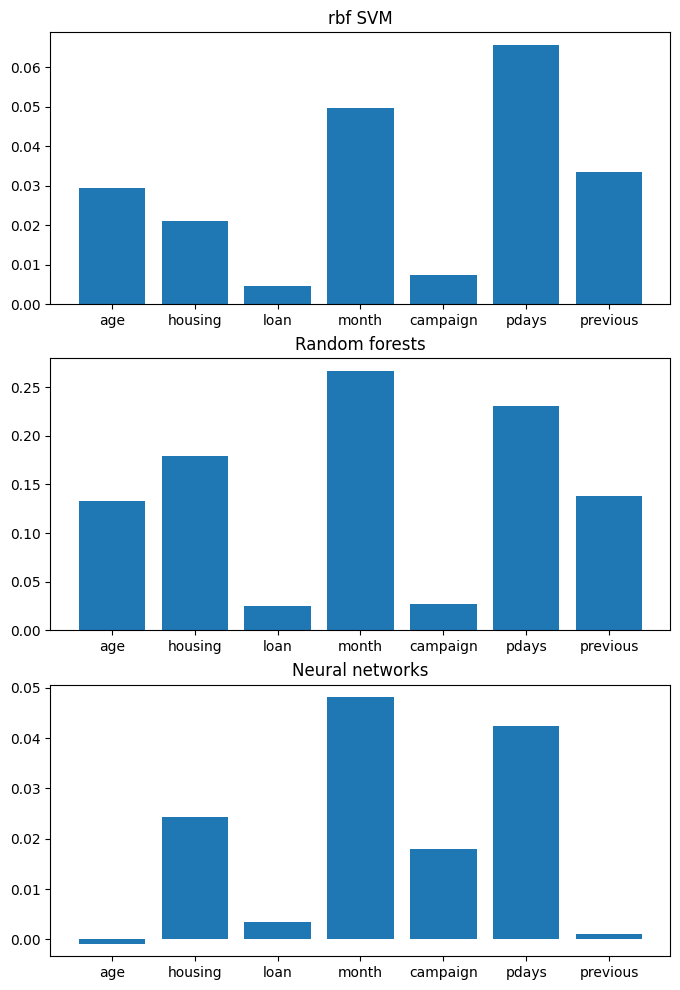

In [ ]:

plt.figure(figsize=(8, 12)) #make the figure

# Plot importances for SVM
plt.subplot(3, 1, 1)
plt.bar(data.columns, SVM_importances.importances_mean)
plt.title('rbf SVM')

# Plot importances for RF
plt.subplot(3, 1, 2)
plt.bar(data.columns, RF_importances)
plt.title('Random forests')

# Plot importances for NN
plt.subplot(3, 1, 3)
plt.bar(data.columns, NN_importances.importances_mean)
plt.title('Neural networks')

plt.show() #show plots



### Note:
RFECV cant be used for neural networks and non-linear SVM since they dont have a coef_ attribute which is required. so i meanually removed the features based on the previous results and checked for accuracy improvements.

In [ ]:
#Qn 7  SVM  #[13]

data=df[['age','month','pdays', 'housing', 'previous']]   #considering only the important features

data_train, data_val, target_train, target_val = train_test_split(data, target, test_size=0.20)  #split the data into training and validation

train_df = pd.concat([data_train, target_train], axis=1)  #create a df including training sets
val_df = pd.concat([data_val, target_val], axis=1)        #create a df including validation sets

model = SVC(kernel='rbf') #create a model for SVM

param_grid = {'C': [10 , 50 , 75], 'gamma': [0.05, 0.01, 0.005]  }  #contains the parameters which will be varied

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='recall', cv=5, n_jobs=-1)   #initialise grid search
grid_search.fit(data_train, target_train)   #obtain the best fit

print("best hyperparameters:", grid_search.best_params_) #print best hyperparams
print("best score:", grid_search.best_score_) #print best score

#  y = column_or_1d(y, warn=True)
# best hyperparameters: {'C': 75, 'gamma': 0.005}
# best score: 0.8490056957171757

In [ ]:
# RF

data=df[['age','housing','loan','month','campaign','pdays','previous']]   #reinit to undo effects of previous cell
data_train, data_val, target_train, target_val = train_test_split(data, target, test_size=0.20)  #split the data into training and validation sets

train_df = pd.concat([data_train, target_train], axis=1)  #create a df including training sets
val_df = pd.concat([data_val, target_val], axis=1)        #create a df including validation sets

rf = RandomForestClassifier()   #create RF model

rfecv = RFECV(estimator=rf, cv=5, scoring='recall')   #initialise RFECV for obtaining the best features
rfecv.fit(data_train, target_train)   #perform the fitting process

print("ranking:", rfecv.ranking_)   #print the feature rankings
print("best features:", rfecv.support_)  #print the optimal features to be used

imp_features = rfecv.support_   #just assigned to a variable

data_selected_train=pd.DataFrame() #create a new df for training features which only has the important ones
for i in range(len(imp_features)): #loop through all important features
    if (imp_features[i]):  #checks if its important
        data_selected_train[str(train_df.columns[i])]=train_df[[str(train_df.columns[i])]] #insert into the df

data_selected_test=pd.DataFrame()   #create a new df for test features which only has the important ones
for i in range(len(imp_features)):   #loop through all important features
    if (imp_features[i]):   #checks if its important
        data_selected_test[str(val_df.columns[i])]=val_df[[str(val_df.columns[i])]]   #insert into the df

param_grid = {'max_depth': [5, 10, 15, 20], 'max_features': [0.1,0.3,0.5,0.7,1]}  #contains the parameters which will be varied

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)   #initialise grid search
grid_search.fit(data_selected_train, target_train)   #obtain the best fit

print("best hyperparameters:", grid_search.best_params_) #print best hyperparams
print("best score:", grid_search.best_score_) #print best score



# return fit_method(estimator, *args, **kwargs)
# best hyperparameters: {'max_depth': 5, 'max_features': 0.5}
# best score: 0.9183757844222962

In [ ]:
#NN

data=df[['housing','month','pdays','campaign']]    #considering only the important features manually chosen

data_train, data_val, target_train, target_val = train_test_split(data, target, test_size=0.20)  #split data into training and validation

train_df = pd.concat([data_train, target_train], axis=1)  #create a df including training sets
val_df = pd.concat([data_val, target_val], axis=1)        #create a df including validation sets

model=MLPClassifier(activation='relu')  #define the NN model

param_grid = {'hidden_layer_sizes': [(10,), (100,), (200,)], 'alpha': [0.0001, 0.001, 0.01] }   #contains the parameters which will be varied

grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, scoring='recall')   #initialise grid search
grid_search.fit(data_train, target_train)  #obtain the best fit

print("best hyperparameters:", grid_search.best_params_) #print best hyperparams
print("best score:", grid_search.best_score_) #print best score

#  y = column_or_1d(y, warn=True)
# best hyperparameters: {'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
# best score: 0.8101947522489408

### Change in scores after feature elimination:

SVM : 0.837 -> 0.849

RF: 0.868 -> 0.918

MLP: 0.78 -> 0.81

- good improvement in random forest and NN
- we observe that there hasn't been much improvements in SVM




As we can observe from the previous test results, the scores are above 80% for all the 3 models with Random forests performing the best at 91.8%.

Anything with a fair prediction rate (> ~70%) can be considered profitable for the company. Random forest is a really good model considering the score value

In [ ]:
# SVM

data=df[['age','month','pdays','deposit']]  #set important features

train = data[~df['month'].isin([1,2])]  #contains all rows which doesnt contain june and july (encoded as 1,2)    #[15]
val = data[df['month'].isin([1,2])]    # contains all rows which contains june and july (encoded as 1,2)

data_train = train.drop('deposit',axis='columns')  #drop target value to create features array
target_train = train['deposit'] #create training target array

data_val = val.drop('deposit',axis='columns')   #drop target value to create features array
target_val = val['deposit']#create validation target array

model = SVC(kernel='rbf') #define SVM model

model.fit(data_train, target_train) #fit the model using training data
prediction = model.predict(data_val)  #predict using validation data
print("accuracy:", accuracy_score(target_val, prediction)) #compare prediction with actual values  #[9]

accuracy: 0.6498538011695907


In [ ]:
# RF

data=df[['pdays','deposit']]  #set important features

train = data[~df['month'].isin([1,2])]  #contains all rows which doesnt contain june and july (encoded as 1,2)
val = data[df['month'].isin([1,2])]    # contains all rows which contains june and july (encoded as 1,2)

#split data into features in target for training
data_train = train.drop('deposit',axis='columns')
target_train = train['deposit']

#split data into features in target for validation
data_val = val.drop('deposit',axis='columns')
target_val = val['deposit']

rf = RandomForestClassifier()   #create RF model


model.fit(data_train, target_train) #fit the model using training data
prediction = model.predict(data_val)  #predict using validation data
print("accuracy:", accuracy_score(target_val, prediction)) #compare prediction with actual values  #[9]


accuracy: 0.6480263157894737


In [ ]:
#NN
data=df[['housing','month','pdays','campaign','deposit']]  #set important features

train = data[~df['month'].isin([1,2])]  #contains all rows which doesnt contain june and july (encoded as 1,2)
val = data[df['month'].isin([1,2])]    # contains all rows which contains june and july (encoded as 1,2)

#split data into features in target for training
data_train = train.drop('deposit',axis='columns')
target_train = train['deposit']

#split data into features in target for validation
data_val = val.drop('deposit',axis='columns')
target_val= val['deposit']

model=MLPClassifier(activation='relu')  #define the NN model


model.fit(data_train, target_train) #fit the model using training data
prediction = model.predict(data_val)  #predict using validation data
print("accuracy:", accuracy_score(target_val, prediction)) #compare prediction with actual values

accuracy: 0.6421783625730995


### observation:

- The score dropped significantly in all 3 cases to ~60%
- There could be a different trend in how deposits are made during june and july because of which the scores might have reduced

In [ ]:
#SVM

data=df[['age','month','pdays','deposit']]  #set important features

train = data[~df['job'].isin([1])]  #contains all rows which doesnt contain technician (encoded as 1)
val = data[df['job'].isin([1])]    # contains all rows which contains technician

#split data into features in target for training
data_train = train.drop('deposit',axis='columns')
target_train = train['deposit']

#split data into features in target for validation
data_val = val.drop('deposit',axis='columns')
target_val = val['deposit']

model = SVC(kernel='rbf') #define SVM model


model.fit(data_train, target_train) #fit the model using training data
prediction = model.predict(data_val)  #predict using validation data
print("accuracy:", accuracy_score(target_val, prediction)) #compare prediction with actual values  #[9]

accuracy: 0.6450905101481075


In [ ]:
#RF

similar_jobs=[]  #init array which will contain jobs with similar scores
data=df[['age','month','pdays','deposit']]   #chosen important features
for i in range(12):  #iteratre through all features
    train = data[~df['job'].isin([i])]  #contains all rows which doesnt contain technician (index 1)
    val = data[df['job'].isin([i])]   # contains all rows which contains technician

#split data into features in target for training
    data_train = train.drop('deposit',axis='columns')
    target_train = train['deposit']

#split data into features in target for validation
    data_val = val.drop('deposit',axis='columns')
    target_val = val['deposit']

    model = SVC(kernel='rbf') #define SVM model


    model.fit(data_train, target_train) #fit the model using training data
    prediction = model.predict(data_val)  #predict using validation data
    print("index:",i) #print feature index
    print("accuracy:", accuracy_score(target_val, prediction)) #compare prediction with actual values  #[9]
    if i==0:
        score0=accuracy_score(target_val, prediction)  #store the score for 0th index feature for later comparison with index 1 ('technician)
    elif i==1:
        score1=accuracy_score(target_val, prediction)  #store value for 1th index feature for comparison
    else:
        if abs(accuracy_score(target_val, prediction)-score1) < 0.005:  #compare the similarity
            similar_jobs.append(i)  #store in array for similar jobs
    print()
if abs(score0-score1):  #compare similarity for 0th index
        similar_jobs.append(0)  #store in array for similar jobs
print(similar_jobs)  #print similar jobs


index: 0
accuracy: 0.6559220389805097

index: 1
accuracy: 0.6450905101481075

index: 2
accuracy: 0.6500541711809318

index: 3
accuracy: 0.6531566640685893

index: 4
accuracy: 0.6439588688946015

index: 5
accuracy: 0.6368312757201646

index: 6
accuracy: 0.6386554621848739

index: 7
accuracy: 0.6554878048780488

index: 8
accuracy: 0.6897810218978102

index: 9
accuracy: 0.8142857142857143

index: 10
accuracy: 0.6518518518518519

index: 11
accuracy: 0.6277777777777778

[2, 4, 0]


0,2,4

In [ ]:
# RF

similar_jobs=[]     #init array which will contain jobs with similar scores
data=df[['pdays','deposit']] #chosen important features
for i in range(12):   #iteratre through all features
    train = data[~df['job'].isin([i])]  #contains all rows which doesnt contain technician (encoded as 1)
    val = data[df['job'].isin([i])]   # contains all rows which contains technician

#split data into features in target for training
    data_train = train.drop('deposit',axis='columns')
    target_train = train['deposit']

#split data into features in target for validation
    data_val = val.drop('deposit',axis='columns')
    target_val = val['deposit']

    rf = RandomForestClassifier()   #create RF model


    model.fit(data_train, target_train) #fit the model using training data
    prediction = model.predict(data_val)  #predict using validation data
    print("index:",i) #print feature index
    print("accuracy:", accuracy_score(target_val, prediction)) #compare prediction with actual values  #[9]
    if i==0:
        score0=accuracy_score(target_val, prediction)  #store the score for 0th index feature for later comparison with index 1 ('technician)
    elif i==1:
        score1=accuracy_score(target_val, prediction)  #store value for 1th index feature for comparison
    else:
        if abs(accuracy_score(target_val, prediction)-score1) < 0.005:  #compare the similarity
            similar_jobs.append(i)  #store in array for similar jobs
    print()
if abs(score0-score1):  #compare similarity for 0th index
        similar_jobs.append(0)  #store in array for similar jobs
print(similar_jobs)  #print similar jobs


index: 0
accuracy: 0.6191904047976012

index: 1
accuracy: 0.6088864509051015

index: 2
accuracy: 0.6543878656554712

index: 3
accuracy: 0.6071706936866719

index: 4
accuracy: 0.538560411311054

index: 5
accuracy: 0.6373456790123457

index: 6
accuracy: 0.6134453781512605

index: 7
accuracy: 0.6463414634146342

index: 8
accuracy: 0.6605839416058394

index: 9
accuracy: 0.7

index: 10
accuracy: 0.6222222222222222

index: 11
accuracy: 0.5138888888888888

[3, 6, 10, 0]


0,3,10

In [ ]:
#NN

similar_jobs=[]     #init array which will contain jobs with similar scores
data=df[['housing','month','pdays','campaign','deposit']] #chosen important features
for i in range(12):   #iteratre through all features
    train = data[~df['job'].isin([i])]  #contains all rows which doesnt contain june and july (encoded as 1,2)
    val = data[df['job'].isin([i])]   # contains all rows which contains june and july (encoded as 1,2)

#split data into features in target for training
    data_train = train.drop('deposit',axis='columns')
    target_train = train['deposit']
#split data into features in target for validation
    data_val = val.drop('deposit',axis='columns')
    target_val = val['deposit']

    model=MLPClassifier(activation='relu')  #define the NN model


    model.fit(data_train, target_train) #fit the model using training data
    prediction = model.predict(data_val)  #predict using validation data
    print("index:",i) #print feature index
    print("accuracy:", accuracy_score(target_val, prediction)) #compare prediction with actual values   #[9]
    if i==0:
        score0=accuracy_score(target_val, prediction)  #store the score for 0th index feature for later comparison with index 1 ('technician)
    elif i==1:
        score1=accuracy_score(target_val, prediction)  #store value for 1th index feature for comparison
    else:
        if abs(accuracy_score(target_val, prediction)-score1) < 0.005:  #compare the similarity
            similar_jobs.append(i)  #store in array for similar jobs
    print()
if abs(score0-score1):  #compare similarity for 0th index
        similar_jobs.append(0)  #store in array for similar jobs
print(similar_jobs)  #print similar jobs


index: 0
accuracy: 0.6611694152923538

index: 1
accuracy: 0.664289632473944

index: 2
accuracy: 0.6663055254604551

index: 3
accuracy: 0.6699142634450507

index: 4
accuracy: 0.6709511568123393

index: 5
accuracy: 0.6486625514403292

index: 6
accuracy: 0.6610644257703081

index: 7
accuracy: 0.6615853658536586

index: 8
accuracy: 0.6824817518248175

index: 9
accuracy: 0.7428571428571429

index: 10
accuracy: 0.6419753086419753

index: 11
accuracy: 0.6972222222222222

[2, 3, 4, 6, 7, 0]


### observation:

- The score dropped significantly in all 3 cases
- indices 0,2,3,4,10 (admin, services, management, self-employed) repeatedly have scores most similar (within 0.01 margin) to index 1 (techician) in when compared over all 3 models
- **only index 0 (admin) is common to all 3 models** to technician, thus can be used as a substitute

## Objective 2


below codes were obtained from:

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
import os, time
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from PIL import Image
from tempfile import TemporaryDirectory
from sklearn.linear_model import LogisticRegression  #to perform logistic regression on the extracted features
from sklearn.metrics import accuracy_score, f1_score #to obtain accuracy and f1 scores

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = r"C:\Users\laksh\Downloads\IITB-Acads\EE\EE353\assignment-3\hymenoptera_data\hymenoptera_data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

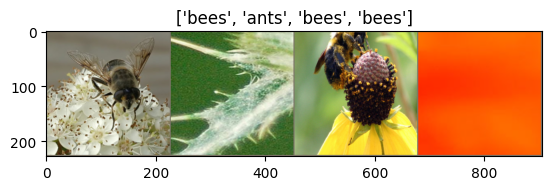

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=24)

Epoch 0/23
----------
train Loss: 0.3883 Acc: 0.8320
val Loss: 0.1847 Acc: 0.9412

Epoch 1/23
----------
train Loss: 0.4221 Acc: 0.8279
val Loss: 0.1779 Acc: 0.9542

Epoch 2/23
----------
train Loss: 0.4078 Acc: 0.8074
val Loss: 0.1764 Acc: 0.9542

Epoch 3/23
----------
train Loss: 0.3162 Acc: 0.8689
val Loss: 0.1699 Acc: 0.9608

Epoch 4/23
----------
train Loss: 0.3413 Acc: 0.8443
val Loss: 0.1753 Acc: 0.9412

Epoch 5/23
----------
train Loss: 0.3925 Acc: 0.8156
val Loss: 0.1969 Acc: 0.9281

Epoch 6/23
----------
train Loss: 0.3865 Acc: 0.8156
val Loss: 0.1785 Acc: 0.9412

Epoch 7/23
----------
train Loss: 0.2898 Acc: 0.8811
val Loss: 0.1818 Acc: 0.9412

Epoch 8/23
----------
train Loss: 0.3265 Acc: 0.8484
val Loss: 0.1781 Acc: 0.9412

Epoch 9/23
----------
train Loss: 0.3354 Acc: 0.8770
val Loss: 0.1833 Acc: 0.9477

Epoch 10/23
----------
train Loss: 0.4797 Acc: 0.8074
val Loss: 0.1750 Acc: 0.9542

Epoch 11/23
----------
train Loss: 0.3940 Acc: 0.8566
val Loss: 0.1745 Acc: 0.9412

Ep

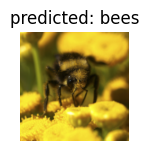

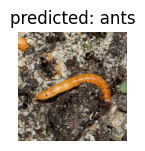

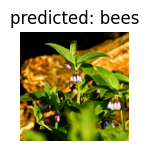

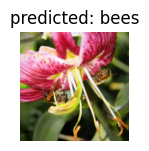

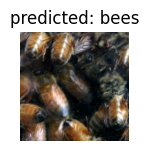

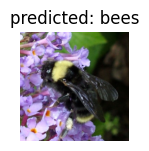

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

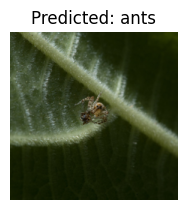

In [ ]:
visualize_model_predictions(
    model_conv,
    img_path=r'C:\Users\laksh\Downloads\IITB-Acads\EE\EE353\assignment-3\hymenoptera_data\hymenoptera_data\val\ants\1247887232_edcb61246c.jpg'
)

plt.ioff()
plt.show()

In [ ]:
#Qn11  #[16]  #[18]
def ExtractFeatures(model, device):  #define function for feature extraction
    feature_extractor = nn.Sequential(*list(model.children())[:-1])  #removes the last layer
    feature_extractor = feature_extractor.to(device)  #move feature extractor to gpu/cpu
    feature_extractor.eval() #set to evaluation mode / disable dropout

    data_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=4, shuffle=True, num_workers=4)  #initialise dataloader as done previously

    all_features = [] #contains features
    all_labels=[] #contains corresponding labels
    for inputs, labels in data_loader:  #go through all images
        inputs = inputs.to(device)  #move input to cpu/gpu
        with torch.no_grad():  # diables gradients for feature extraction
            features = feature_extractor(inputs)  # Get features for corresponding image with dimensions (N, 512, 1, 1)
            features = features.flatten(start_dim=1)  # Reshape to (N, 512) by removing dim. from index 2 onwards        #[17]
            all_features.append(features.cpu().numpy())  #append features to the array
            all_labels.append(labels.cpu().numpy()) #append corresponding label to the array


    feature_array = np.concatenate(all_features, axis=0)  # Concatenate all_features array into a numpy array
    labels_array = np.concatenate(all_labels, axis=0)  # Concatenate all_labels array into a numpy array

    return feature_array, labels_array

features = ExtractFeatures(model_conv,device)[0]  #extract final layer of features
labels = ExtractFeatures(model_conv,device)[1]  #extract labels

#get dimensions of the extracted features array
print(features.shape)
print(labels.shape)



(244, 512)
(244,)


In [ ]:
#Qn12   #[19]

data_train, data_val, target_train, target_val = train_test_split(features, labels, test_size=0.2) #split into training and validation sets

log_reg = LogisticRegression(max_iter=1000)  #create model for lr
param_grid_lr = {'C': [0.01, 0.1, 1,10,100]}  #set range of variation of C parameter

grid_search_lr = GridSearchCV(log_reg, param_grid_lr, scoring='f1', cv=5) #init grid search
grid_search_lr.fit(data_train, target_train) #perform best fit
best_log_reg = grid_search_lr.best_estimator_ #return the best model based on the fit

rf_clf = RandomForestClassifier() # create model for rf
param_grid_rf = {'max_depth': [10, 20, 30, None],'n_estimators': [10, 50, 100]} #the params which we vary

grid_search_rf = GridSearchCV(rf_clf, param_grid_rf, scoring='f1', cv=5)  #init grid search
grid_search_rf.fit(data_train, target_train)  #perform best fit
best_rf = grid_search_rf.best_estimator_ #return best model based on the fit

prediction_lr = best_log_reg.predict(data_val)  #predict classes based on validation data
accuracy_lr = accuracy_score(target_val, prediction_lr)  #get accuracy score for the prediction
f1_lr = f1_score(target_val, prediction_lr)  #get f1_score for the prediction

# Random Forest results
prediction_rf = best_rf.predict(data_val) #predict classes based on validation data
accuracy_rf = accuracy_score(target_val, prediction_rf)    #get accuracy score for the prediction
f1_rf = f1_score(target_val, prediction_rf)    #get f1_score for the prediction

# print the results
print("Logistic regression:")
print("best parameters: ", grid_search_rf.best_params_)
print("accuracy: ", accuracy_rf)
print("F1 score: ", f1_rf)
print()
print("Random forest:")
print("best parameters: ", grid_search_rf.best_params_)
print("accuracy: ", accuracy_rf)
print("F1 score: ", f1_rf)


Logistic regression:
best parameters:  {'max_depth': 30, 'n_estimators': 100}
accuracy:  0.5510204081632653
F1 score:  0.5769230769230769

Random forest:
best parameters:  {'max_depth': 30, 'n_estimators': 100}
accuracy:  0.5510204081632653
F1 score:  0.5769230769230769


All references used are mentioned below

**Source Citations:**


[1] https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html ;
https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html

[2] https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestClassifier.html

[3]  https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

[4]
https://scikit-learn.org/dev/modules/generated/sklearn.metrics.accuracy_score.html ;
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

[5] https://www.geeksforgeeks.org/determining-feature-importance-in-svm-classifiers-with-scikit-learn/ ;
https://scikit-learn.org/1.5/modules/generated/sklearn.inspection.permutation_importance.html ;
https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html ;



[6] https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html

[7]
https://scikit-learn.org/1.5/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html#sklearn.feature_selection.SequentialFeatureSelector ;



[8] https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

[9] https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html

